# **Air Quality Prediction**



In [1]:
import warnings
warnings.filterwarnings('ignore')
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Ingestion Stage

In [2]:
# API RUL
API_URL = "https://api.aqi.in/api/v1/getIndiaLocations"
response = requests.get(API_URL)
# checking request was successful or not
if response.status_code == 200:
    data1 = response.json()
    print(data1)
else:
    print("Error:", response.status_code) # printing error

{'Locations': [{'stationname': 'F Block,Sirsa,Haryana,India', 'locationId': '11850', 'dev_type': 1, 'lat': '29.5364', 'lon': '75.0158', 'Elevation': '200', 'updated_at': '2024-04-14 22:04:04', 'formatdate': '14 Apr 2024, 10:04pm', 'timeStamp': '1709870400', 'cityName': 'Sirsa', 'stateName': 'Haryana', 'countryName': 'India', 'source': 'World Air Quality Index Project', 'sourceUrl': 'https://waqi.info', 'airComponents': [{'sensorName': 'co', 'sensorData': 1185, 'senDevId': 'co', 'sensorUnit': 'ppb'}, {'sensorName': 'no2', 'sensorData': 4, 'senDevId': 'no2', 'sensorUnit': 'ppb'}, {'sensorName': 'o3', 'sensorData': 27, 'senDevId': 'o3', 'sensorUnit': 'ppb'}, {'sensorName': 'pm10', 'sensorData': 86, 'senDevId': 'pm10', 'sensorUnit': 'ug/m3'}, {'sensorName': 'pm25', 'sensorData': 34, 'senDevId': 'pm25', 'sensorUnit': 'ug/m3'}, {'sensorName': 'so2', 'sensorData': 6, 'senDevId': 'so2', 'sensorUnit': 'ppb'}, {'sensorName': 'AQI-IN', 'sensorData': 86, 'senDevId': 'AQI-IN', 'sensorUnit': 'IN-AQI

# 2. Data Cleaning Stage

In [3]:
data = pd.json_normalize(data1, 'Locations')


In [4]:
sensor_val = pd.json_normalize(data['airComponents'])
sensor_val.shape
sensor = pd.DataFrame()
for col in sensor_val.columns:
    col_name = sensor_val[col][0]['sensorName'] + "_" + sensor_val[col][0]['sensorUnit']
    sensor[col_name] = sensor_val[col].apply(lambda x: x['sensorData'])


In [5]:
final_data = pd.merge(data, sensor, left_index = True, right_index = True)

# dropping those column that are not needed for the prediction purpose.
final_data.drop(columns = ['stationname', 'locationId','formatdate' ,'dev_type', 'updated_at', 'timeStamp', 'cityName', 'stateName',
       'countryName', 'source', 'sourceUrl', 'airComponents' ], inplace = True)

final_data.columns

Index(['lat', 'lon', 'Elevation', 'co_ppb', 'no2_ppb', 'o3_ppb', 'pm10_ug/m3',
       'pm25_ug/m3', 'so2_ppb', 'AQI-IN_IN-AQI', 'aqi_US-AQI', 't_C', 'p_mb',
       'dew_C', 'h_%', 'w_km/h', 'wd_'],
      dtype='object')

# 3. EDA

In [6]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lat            379 non-null    object
 1   lon            379 non-null    object
 2   Elevation      355 non-null    object
 3   co_ppb         379 non-null    int64 
 4   no2_ppb        379 non-null    int64 
 5   o3_ppb         379 non-null    int64 
 6   pm10_ug/m3     379 non-null    int64 
 7   pm25_ug/m3     379 non-null    int64 
 8   so2_ppb        379 non-null    int64 
 9   AQI-IN_IN-AQI  379 non-null    int64 
 10  aqi_US-AQI     379 non-null    int64 
 11  t_C            379 non-null    int64 
 12  p_mb           379 non-null    int64 
 13  dew_C          379 non-null    int64 
 14  h_%            379 non-null    int64 
 15  w_km/h         379 non-null    int64 
 16  wd_            379 non-null    int64 
dtypes: int64(14), object(3)
memory usage: 50.5+ KB


**Observation:**
1.  Latitude, longitude and elivation columns are in object format. They need to be changed into numerical column.  

In [7]:
final_data['lon'] = pd.to_numeric(data['lon'])
final_data['lat'] = pd.to_numeric(data['lat'])
final_data['Elevation'] = pd.to_numeric(data['Elevation'])

In [8]:
#Checking for null values
final_data.isna().sum()

lat               0
lon               0
Elevation        24
co_ppb            0
no2_ppb           0
o3_ppb            0
pm10_ug/m3        0
pm25_ug/m3        0
so2_ppb           0
AQI-IN_IN-AQI     0
aqi_US-AQI        0
t_C               0
p_mb              0
dew_C             0
h_%               0
w_km/h            0
wd_               0
dtype: int64

In [9]:
# Filling null values by mean in column Elevation
final_data['Elevation'] = final_data['Elevation'].fillna(final_data['Elevation'].mean())

In [10]:
final_data.describe()

,lat,lon,Elevation,co_ppb,no2_ppb,o3_ppb,pm10_ug/m3,pm25_ug/m3,so2_ppb,AQI-IN_IN-AQI,aqi_US-AQI,t_C,p_mb,dew_C,h_%,w_km/h,wd_
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.00000
mean,22.624944,78.704557,275.873239,757.168865,17.284960,15.503958,117.163588,47.963061,6.525066,118.192612,117.387863,28.564644,975.651715,18.562005,56.182058,6.467018,230.16095
std,6.150064,4.702963,304.313840,636.870052,16.928048,10.937623,98.580935,45.896291,20.090043,100.541562,56.481349,3.345678,38.442840,4.016267,15.442198,4.512867,117.15622
min,8.514057,72.456691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,9.000000,3.000000,673.000000,-3.000000,29.000000,0.000000,1.00000
25%,18.478676,76.119186,57.500000,370.000000,5.000000,8.000000,64.000000,26.500000,2.000000,66.500000,82.000000,27.000000,960.000000,16.000000,45.000000,3.000000,117.00000
50%,24.261301,77.400574,211.000000,629.000000,12.000000,13.000000,92.000000,38.000000,4.000000,94.000000,107.000000,29.000000,985.000000,18.000000,52.000000,5.000000,278.00000
75%,28.398842,80.256231,318.500000,981.000000,23.000000,20.000000,133.000000,54.000000,7.000000,130.500000,151.000000,31.000000,1002.000000,21.000000,69.500000,8.500000,333.50000
max,34.161190,94.098988,2228.000000,6910.000000,95.000000,69.000000,1026.000000,604.000000,382.000000,1145.000000,499.000000,35.000000,1012.000000,27.000000,100.000000,21.000000,360.00000


In [11]:
# def air_quality(aqi_value):
#     if aqi_value <= 50:
#         return "Good"
#     elif 51 <= aqi_value <= 100:
#         return "Moderate"
#     elif 101 <= aqi_value <= 200:
#         return "Poor"
#     elif 201 <= aqi_value <= 300:
#         return "Unhealthy"
#     elif 301 <= aqi_value <= 400:
#         return "Very Unhealthy"
#     else:
#         return "Hazardous"

# # Creating a 'Classify_AQI' column, use the air_quality function.
# final_data['Classify_AQI'] = final_data['AQI-IN_IN-AQI'].apply(lambda x: air_quality(x))

# final_data.head(5)

In [12]:
# Observation max value of AQI-IN is 1094 which might be an outliers. Analyzing the same data.
final_data[final_data['AQI-IN_IN-AQI'] > 500]

,lat,lon,Elevation,co_ppb,no2_ppb,o3_ppb,pm10_ug/m3,pm25_ug/m3,so2_ppb,AQI-IN_IN-AQI,aqi_US-AQI,t_C,p_mb,dew_C,h_%,w_km/h,wd_
109,17.320057,76.820889,462.0,777,13,16,1026,604,3,1145,15,33,957,19,42,3,9
141,22.998789,72.602966,52.0,1203,43,24,603,255,15,616,499,29,1004,18,51,0,360
216,25.619651,85.147382,58.0,1568,6,14,651,194,7,677,244,32,1002,22,55,0,360
268,23.243639,72.689940,78.0,280,15,15,523,226,3,516,419,29,1001,18,51,12,326
269,23.043070,72.562968,52.0,722,17,6,534,228,5,530,430,29,1004,18,51,0,360


In [13]:
# It is observed that the data AQI IN is 1094 and AQI-US is 0 which does not make any sense in the data. Thus dropping the data.
final_data.drop(index = final_data[final_data['AQI-IN_IN-AQI'] > 1000].index, inplace = True)

**Univariate analysis**


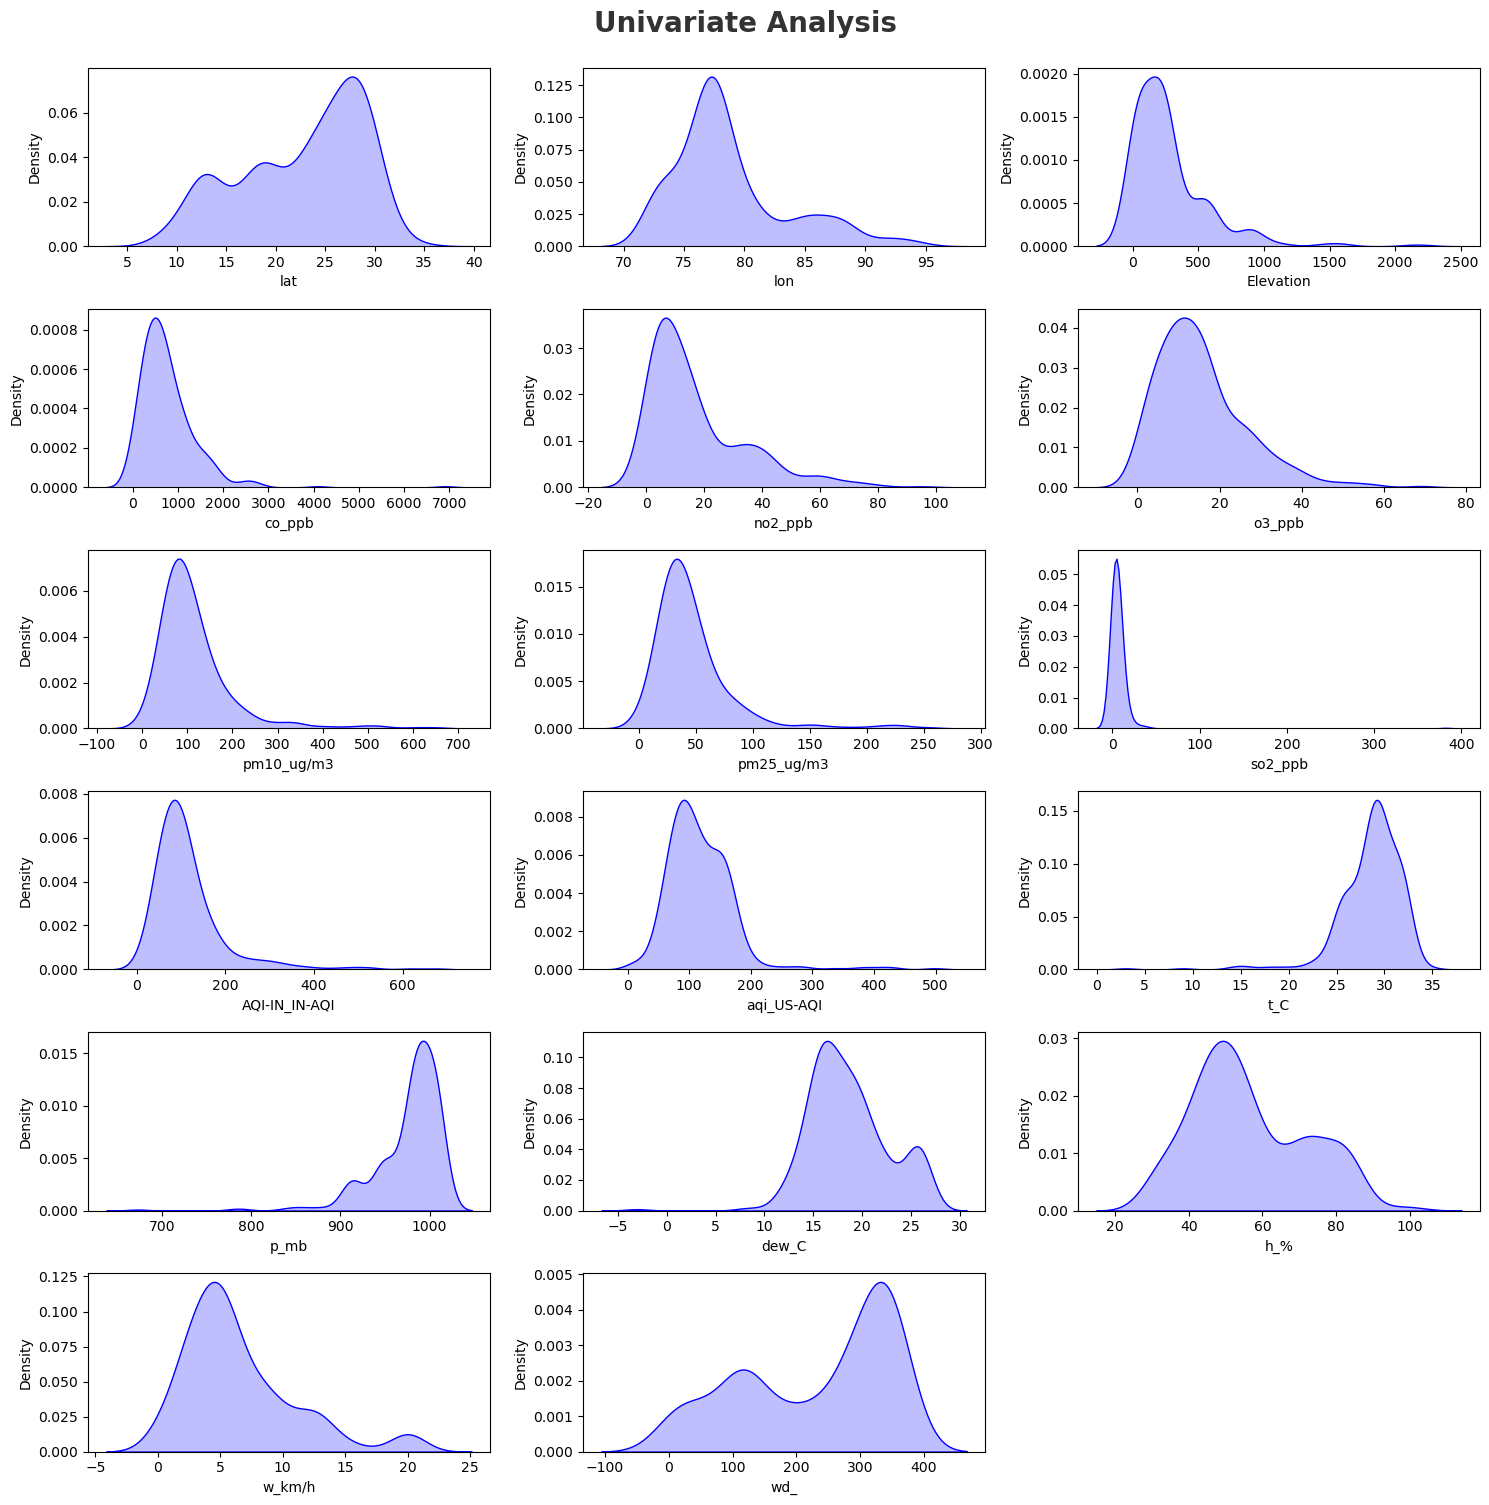

In [14]:
numerical_features = [col for col in final_data.columns if final_data[col].dtypes != 'O']
len(numerical_features)
plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numerical_features)):
    plt.subplot(6,3 , i+1)
    sns.kdeplot(x=final_data[numerical_features[i]],shade=True, color='b')
    plt.xlabel(numerical_features[i])
    plt.tight_layout()

**Multivariate Analysis**

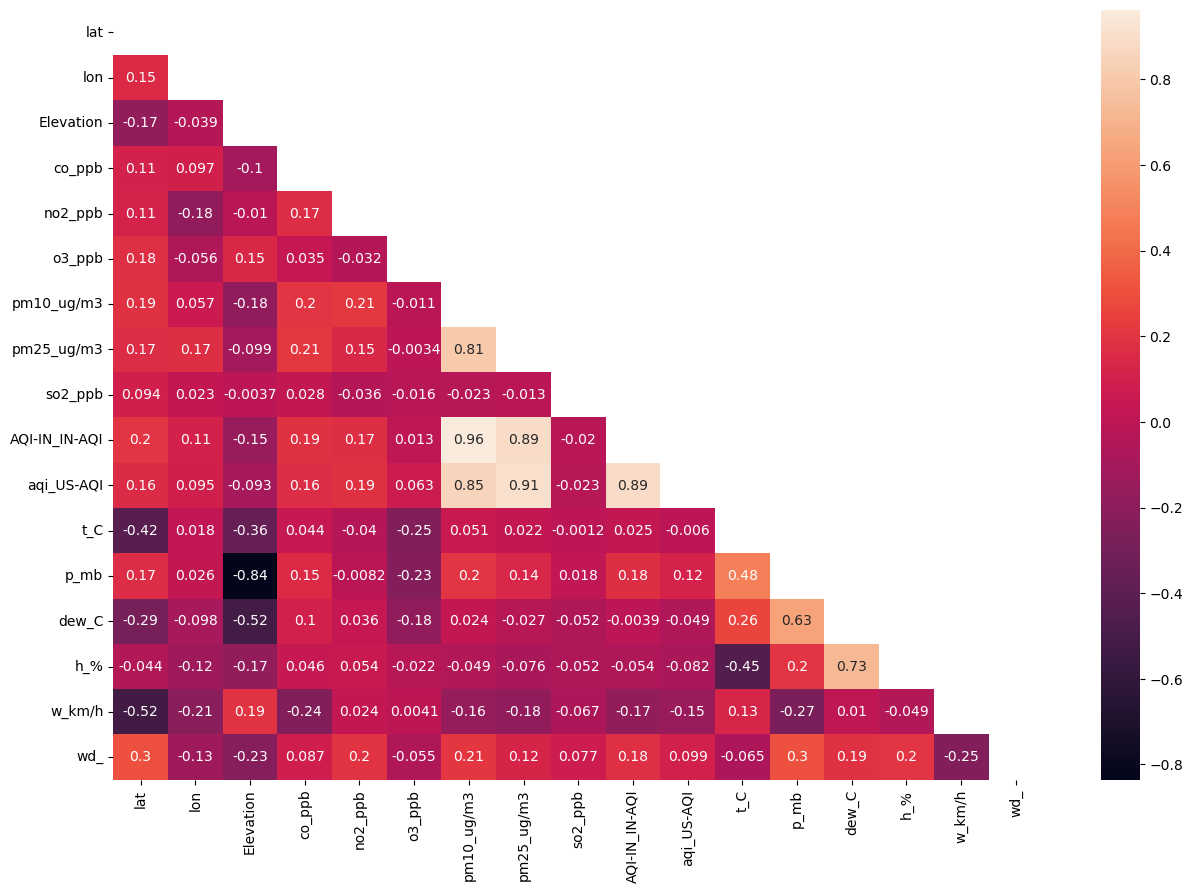

In [15]:
# Select only numeric columns
numeric_columns = final_data.select_dtypes(include=np.number)

# Plot heatmap
plt.figure(figsize=(15, 10))
matrix = np.triu(numeric_columns.corr())
sns.heatmap(numeric_columns.corr(), annot=True, mask=matrix)
plt.yticks(rotation=0)
plt.show()


In [16]:
import math

def haversine(lat1, lon1, lat2, lon2, earth_radius=6371.0):
    """
    Calculates the great circle distance between two points
    on the Earth's surface using the Haversine formula.

    :param lat1: Latitude of the first point
    :param lon1: Longitude of the first point
    :param lat2: Latitude of the second point
    :param lon2: Longitude of the second point
    :param earth_radius: Radius of the Earth (default is in kilometers)
    :return: Distance between the two points in kilometers
    """
    try:
        # Convert decimal degrees to radians
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
        c = 2 * math.asin(math.sqrt(a))
        distance = earth_radius * c
        return distance

    except Exception as e:
        raise e

In [17]:
# User's location
user_lat = float(input("Enter the lat: "))  # User's latitude
user_lon = float(input("Enter the lon: "))  # User's longitude

# Calculate distance for each location in the dataset
final_data['distance'] = final_data.apply(lambda row: haversine(user_lat, user_lon, row['lat'], row['lon']), axis=1)



Enter the lat: 28.6145
Enter the lon: 77.2071


In [18]:
final_data

,lat,lon,Elevation,co_ppb,no2_ppb,o3_ppb,pm10_ug/m3,pm25_ug/m3,so2_ppb,AQI-IN_IN-AQI,aqi_US-AQI,t_C,p_mb,dew_C,h_%,w_km/h,wd_,distance
0,29.536400,75.015800,200.000000,1185,4,27,86,34,6,86,97,26,986,19,64,6,226,236.337081
1,30.233011,74.907758,207.000000,1762,12,22,89,89,10,197,168,25,986,19,69,2,329,286.312050
2,31.619980,74.876485,233.000000,79,6,25,89,53,7,89,144,22,984,20,88,8,19,402.382560
3,23.520444,87.311923,109.000000,1589,33,15,129,64,10,120,155,29,996,18,51,4,205,1156.670104
4,26.144500,91.736200,50.000000,1429,6,9,214,81,16,176,164,27,1003,22,74,5,190,1459.641699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,12.969219,77.608279,275.873239,205,42,9,110,46,2,107,127,32,912,12,30,20,111,1740.171175
375,12.920504,77.609694,275.873239,279,28,10,88,30,2,88,89,27,913,15,47,20,109,1745.590180
376,27.310130,88.596870,275.873239,370,2,27,40,19,4,40,66,18,874,13,70,5,49,1127.546908
377,28.423252,77.067220,275.873239,875,40,29,111,82,1,174,165,26,983,18,61,3,348,25.278666


In [19]:
# list of radii
radii = [10, 20, 30 ,40, 50,70,80, 90, 100, 150]

# Filter and store data for each radius
for radius in radii:
    # Filter locations within the radius
    nearby_locations = final_data[final_data['distance'] <= radius]
    print(len(nearby_locations))
    # Check if there are any locations within the radius
    if len(nearby_locations) >= 3 :
        # Append the filtered dataframe to the list
        break


nearby_locations.reset_index(inplace = True)

nearby_locations

11


,index,lat,lon,Elevation,co_ppb,no2_ppb,o3_ppb,pm10_ug/m3,pm25_ug/m3,so2_ppb,AQI-IN_IN-AQI,aqi_US-AQI,t_C,p_mb,dew_C,h_%,w_km/h,wd_,distance
0,130,28.620171,77.287705,206.0,921,45,12,184,38,3,156,115,25,985,20,74,4,358,7.893175
1,139,28.661975,77.124156,216.0,1162,64,11,218,68,4,179,157,29,985,20,57,8,350,9.663898
2,146,28.528344,77.189304,241.0,567,61,7,99,32,4,99,93,25,981,20,74,4,352,9.736458
3,164,28.582846,77.234366,213.0,1216,61,5,88,20,3,88,68,25,984,20,74,8,347,4.413010
4,165,28.695720,77.181295,222.0,969,30,2,175,39,8,150,111,26,984,20,71,5,350,9.375691
5,169,28.630362,77.197293,231.0,922,72,3,108,36,3,106,102,25,982,20,74,8,347,2.006784
6,183,28.566008,77.176743,233.0,1803,77,10,156,53,8,137,144,25,982,20,74,4,352,6.152994
7,189,28.636997,77.172248,235.0,1812,14,3,133,34,4,122,97,25,982,20,74,4,352,4.222455
8,200,28.566827,77.251418,216.0,1164,5,4,123,34,1,115,97,25,984,20,74,4,347,6.842787
9,210,28.635760,77.224450,212.0,948,61,3,139,42,4,126,117,25,985,20,74,4,347,2.907957


In [20]:
nearby_locations['weights'] = nearby_locations.apply(lambda row: 1/row['distance'], axis = 1)
weighted_values = nearby_locations.drop(columns = ['Elevation','index', 'lat', 'lon', 'distance','AQI-IN_IN-AQI','aqi_US-AQI'])
# weighted_values = nearby_locations.drop(columns = ['Elevation','index', 'lat', 'lon', 'distance','aqi_US-AQI'])


In [21]:
weighted_values = weighted_values.apply(lambda row: row*row['weights'], axis = 1)
weighted_values['weights'] = nearby_locations['weights']

In [22]:
average_values = weighted_values.sum()/ weighted_values['weights'].sum()
values= pd.DataFrame ([average_values], columns = weighted_values.columns).drop(columns = ['weights'])
# Print the average values
print("Average values:")
print(values)

Average values:
        co_ppb    no2_ppb    o3_ppb  pm10_ug/m3  pm25_ug/m3  so2_ppb  \
0  1090.049427  55.753038  5.523057  130.018296   40.032513  3.76974   

         t_C        p_mb  dew_C        h_%    w_km/h         wd_  
0  25.217712  983.360382   20.0  73.130483  5.430397  348.896329  


#4. Model Building

In [23]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [24]:
# final_data.columns

In [25]:
x =  final_data[['co_ppb', 'no2_ppb', 'o3_ppb', 'pm10_ug/m3','pm25_ug/m3', 'so2_ppb', 't_C', 'p_mb','dew_C', 'h_%', 'w_km/h', 'wd_']]
y = final_data[['AQI-IN_IN-AQI']]

In [26]:
# train and test split
x_train, x_test, y_train,y_test = train_test_split(x, y, test_size = .25, random_state = 50)

In [27]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [28]:
# Elastic Net Regression
# model_elastic = ElasticNet()
# model_elastic.fit(x_train, y_train)
# y_pred_elastic = model_elastic.predict(x_test)


In [29]:
#    Calculating Adjusted R2 score    #

# score_ridge = r2_score(y_test, y_pred_ridge)
# score_lasso = r2_score(y_test, y_pred_lasso)
# score_elastic = r2_score(y_test, y_pred_elastic)
# score_xgboost = r2_score(y_test, y_pred_XGboost)

# print('Adjusted r2 score Ridge', end = ' ')
# print(1 - (1-score_ridge)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
# print('Adjusted r2 score Lasso', end = ' ')
# print(1 - (1-score_lasso)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
# print('Adjusted r2 score Elastic', end = ' ')
# print(1 - (1-score_elastic)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
# print('Adjusted r2 score XGBoost', end = ' ')
# print(1 - (1-score_xgboost)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))


In [44]:
# XGB_model = XGBRegressor(fit_intercept=True)
# XGB_model = XGB_model.fit(x_train, y_train)
# y_pred = XGB_model.predict(x_test)
# score = r2_score(y_test, y_pred)*100
# print(" Accuracy of the model is %.2f" %score)

In [31]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [32]:
models = {
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor()
}

model_list = []
r2_list = []

# hyperparameters for each model
param_grid = {
    "Lasso": {'alpha': [0.1, 0.5, 1.0]},
    "Ridge": {'alpha': [0.1, 0.5, 1.0]},
    "K-Neighbors Regressor": {'n_neighbors': [3, 5, 7]},
    "Decision Tree": {'max_depth': [3, 5, 7]},
    "Random Forest Regressor": {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]},
    "XGBRegressor": {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}
}

best_models = {}

for model_name, model in models.items():
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid[model_name], n_iter=5, cv=3, scoring='r2', verbose=2, random_state=42)

    random_search.fit(x_train, y_train)

    best_model = random_search.best_estimator_
    best_models[model_name] = best_model

    y_train_pred = best_model.predict(x_train)
    y_test_pred = best_model.predict(x_test)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    model_list.append(model_name)
    r2_list.append(model_test_r2)

    print(model_name)
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    print('----------------------------------')
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print('='*35)
    print('\n')

best_models

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
Lasso
Model performance for Training set
- Root Mean Squared Error: 16.9662
- Mean Absolute Error: 10.7874
- R2 Score: 0.9654
----------------------------------
Model performance for Test set
- Root Mean Squared 

{'Lasso': Lasso(alpha=0.5),
 'Ridge': Ridge(alpha=0.1),
 'K-Neighbors Regressor': KNeighborsRegressor(n_neighbors=3),
 'Decision Tree': DecisionTreeRegressor(max_depth=7),
 'Random Forest Regressor': RandomForestRegressor(max_depth=5, n_estimators=200),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, 

In [33]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
5,XGBRegressor,0.980965
4,Random Forest Regressor,0.976681
3,Decision Tree,0.971954
0,Lasso,0.944608
1,Ridge,0.926573
2,K-Neighbors Regressor,0.812107


In [34]:
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (283, 12)
X_test shape: (95, 12)
y_train shape: (283, 1)
y_test shape: (95, 1)


In [35]:
XGB_model = XGBRegressor(fit_intercept=True)
XGB_model = XGB_model.fit(x_train, y_train)
y_pred = XGB_model.predict(x_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 97.94


In [36]:
rf_model = RandomForestRegressor()
rf_model = rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 97.75


In [37]:
dt_model = DecisionTreeRegressor()
dt_model = dt_model.fit(x_train, y_train)
y_pred = dt_model.predict(x_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 97.54


In [38]:
scaled_value = scaler.transform(values)

AQI = rf_model.predict(scaled_value)
AQI

array([119.7])

Plot y_pred and y_test

Text(0, 0.5, 'Predicted')

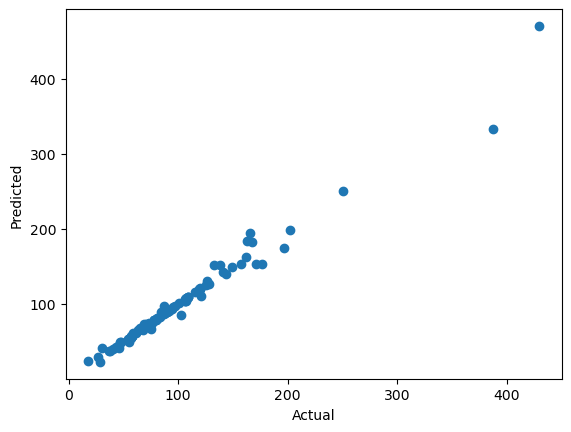

In [39]:
plt.scatter(y_test, y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted')

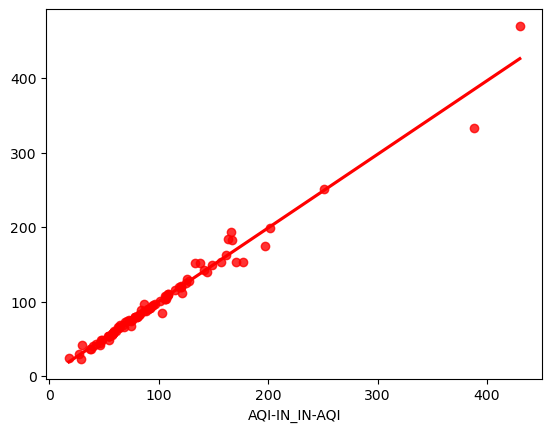

In [40]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

In [45]:
import pickle
import joblib

with open("model.pkl", "wb") as f:
    mp = pickle.dump(XGB_model, f)

In [46]:
joblib.dump(XGB_model, 'model_joblib')

['model_joblib']

In [47]:
mj = joblib.load('model_joblib')
print(mj)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             fit_intercept=True, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)
